In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from collections import Counter
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.metrics import classification_report, confusion_matrix

##### Data Splitting

In [28]:
# Load the cleaned data from the CSV file and print its shape
cleaned_data = pd.read_csv('../data/cleaned-data.csv')
print(f"Shape of the cleaned data: {cleaned_data.shape}")

Shape of the cleaned data: (32124, 34)


In [29]:
# Split the data into features (X) and target (y)
X = cleaned_data.drop(columns=['y'])  # Features
y = cleaned_data['y']  # Target

# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


#### Neural Network

##### Step 1: Apply Correlation Matrix and Remove Correlated Features

In [30]:
# Calculate correlation matrix
corr_matrix = X_train.corr()

# Set a threshold for correlation (e.g., 0.8)
threshold = 0.8
correlated_features = set()

# Loop through the matrix to find correlated features
for i in range(len(corr_matrix.columns)):
    for j in range(i):
        if abs(corr_matrix.iloc[i, j]) > threshold:
            colname = corr_matrix.columns[i]
            correlated_features.add(colname)

# Drop the correlated features
X_train = X_train.drop(columns=correlated_features)
X_test = X_test.drop(columns=correlated_features)

print(X_train.head())  # Show the updated dataframe after dropping correlated features

            age  housing  loan  contact  duration  campaign  pdays  previous  \
4291  -0.290177        0     0        1 -0.780232  0.155984      1 -0.349551   
15230  0.669465        1     0        0 -0.421577 -0.204990      1 -0.349551   
25402  0.477537        0     0        1  1.090173 -0.565963      1 -0.349551   
25772  0.861394        0     1        0  0.087482 -0.204990      1 -0.349551   
5533   0.093680        0     0        1 -0.367586 -0.204990      1 -0.349551   

       emp.var.rate  cons.price.idx  ...  marital_married  marital_single  \
4291            1.1        0.722628  ...             True           False   
15230           1.4        0.591329  ...            False           False   
25402          -1.8       -0.865052  ...            False            True   
25772          -1.8       -0.865052  ...             True           False   
5533            1.1        0.722628  ...             True           False   

       poutcome_nonexistent  poutcome_success  education

##### Step 2: Apply SMOTE (Synthetic Minority Over-sampling Technique)

In [31]:
# Apply SMOTE on the training data
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

print(f"Training set after SMOTE: {Counter(y_train_smote)}")

Training set after SMOTE: Counter({0: 23429, 1: 23429})


##### Step 4: Define and Compile Neural Network Model

In [32]:
# Define the Neural Network
nn_model = Sequential([
    Dense(64, activation='tanh', input_dim=X_train_smote.shape[1]),  # Input layer
    Dropout(0.3),  # Prevent overfitting
    Dense(32, activation='tanh'),  # Hidden layer
    Dropout(0.3),  # Prevent overfitting
    Dense(1, activation='sigmoid')  # Output layer for binary classification
])

# Compile the model
nn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

C:\Users\Nethma\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


##### Step 5: Train the Neural Network Model

In [33]:
# Train the model
history = nn_model.fit(X_train_smote, y_train_smote, validation_data=(X_test, y_test),
                        epochs=20, batch_size=32, verbose=1)


Epoch 1/20
1465/1465 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.8458 - loss: 0.3681 - val_accuracy: 0.8476 - val_loss: 0.3383
Epoch 2/20
1465/1465 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8796 - loss: 0.3021 - val_accuracy: 0.8528 - val_loss: 0.3243
Epoch 3/20
1465/1465 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8808 - loss: 0.2913 - val_accuracy: 0.8339 - val_loss: 0.3538
Epoch 4/20
1465/1465 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8850 - loss: 0.2841 - val_accuracy: 0.8562 - val_loss: 0.3028
Epoch 5/20
1465/1465 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.8858 - loss: 0.2825 - val_accuracy: 0.8549 - val_loss: 0.3144
Epoch 6/20
1465/1465 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.8847 - loss: 0.2808 - val_accuracy: 0.8473 - val_loss: 0.3347
Epoch 7/20
1465/1465 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.8870 - loss: 0.2771 - val_accuracy: 0.8512 - val_loss: 0.3281
Epoch 8/20
1465/1465 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8893 - loss: 0.2753 - 

##### Step 6: Evaluate Model and Print Results

In [34]:
# Predict on the test set
y_pred = nn_model.predict(X_test)
y_pred = (y_pred > 0.5).astype(int)  # Convert probabilities to binary predictions

# Evaluate the model on the test set
test_loss, test_accuracy = nn_model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

# Classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8621 - loss: 0.2991
Test Loss: 0.2938362658023834
Test Accuracy: 0.8636575937271118
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.87      0.92      5826
           1       0.39      0.84      0.54       599

    accuracy                           0.86      6425
   macro avg       0.69      0.86      0.73      6425
weighted avg       0.93      0.86      0.88      6425

Confusion Matrix:
[[5043  783]
 [  93  506]]


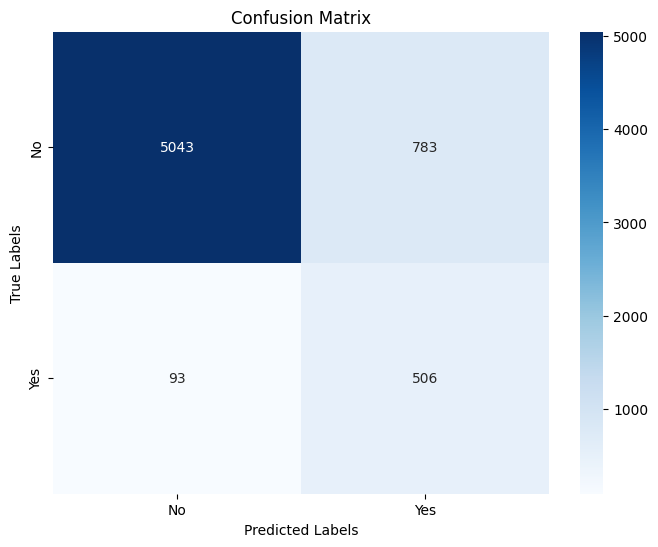

In [35]:
# Function to plot the confusion matrix
def plot_confusion_matrix(cm, class_names):
    """
    Plots a confusion matrix using seaborn's heatmap.
    
    Parameters:
    - cm: Confusion matrix (as a 2D array).
    - class_names: List of class names.
    """
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()

# Plot the confusion matrix
class_names = ['No', 'Yes']  # Adjust based on your target variable
plot_confusion_matrix(cm, class_names)

Random Forest

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.94      0.95      8777
           1       0.50      0.58      0.54       861

    accuracy                           0.91      9638
   macro avg       0.73      0.76      0.74      9638
weighted avg       0.92      0.91      0.91      9638

Confusion Matrix:
[[8268  509]
 [ 360  501]]
AUC-ROC Score: 0.93


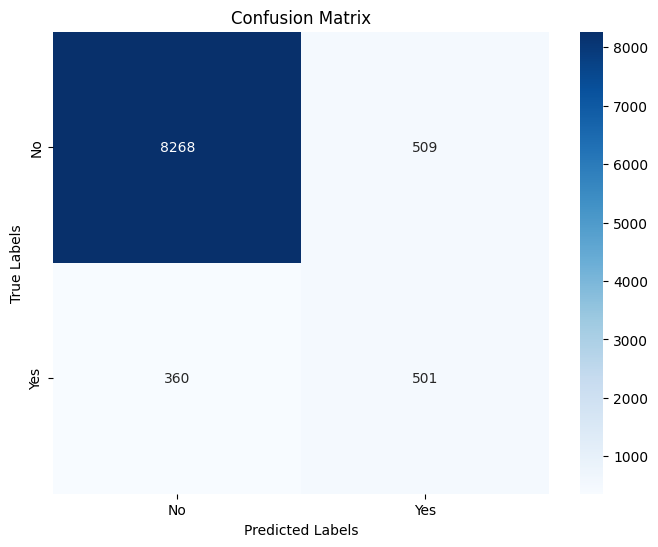

In [36]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

# Load your dataset
# Assume X contains features and y contains target labels
# Example: X, y = df.drop(columns='target'), df['target']

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Handle data imbalance using SMOTE
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Alternatively, use RandomUnderSampler for undersampling
rus = RandomUnderSampler(random_state=42)
X_train_resampled, y_train_resampled = rus.fit_resample(X_train, y_train)

# Initialize the Random Forest Classifier with class weight
rf = RandomForestClassifier(
    n_estimators=100,         # Number of trees
    random_state=42,          # Random seed for reproducibility
    class_weight="balanced"   # Assign weights inversely proportional to class frequencies
)

# Train the Random Forest model
rf.fit(X_train_smote, y_train_smote)

# Make predictions
y_pred = rf.predict(X_test)
y_pred_proba = rf.predict_proba(X_test)[:, 1]

# Evaluate the model
print("Classification Report:")
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

# AUC-ROC Score
auc = roc_auc_score(y_test, y_pred_proba)
print(f"AUC-ROC Score: {auc:.2f}")

plot_confusion_matrix(cm, class_names)